In [1]:
# import all necessary packages
import glob
import pickle
import warnings

import numpy as np
import pandas as pd

from drugpk.training.scorers.predictors import Predictor

from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import PandasTools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns



base_dir = "Lombardo_set"

          Train  Test
Property             
CL         1141   127
VDss       1112   124
fu          790    88


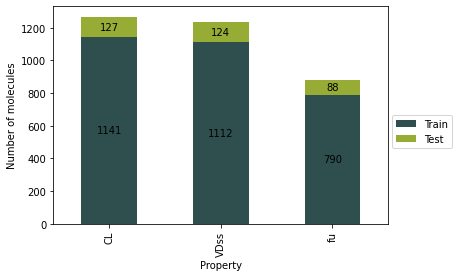

In [8]:
### plot train and test set size

my_cmap = ListedColormap(["darkslategrey", "#96AC35"])

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')

data_objs = [pickle.load(open(fname, 'rb')) for fname in fnames]

data = np.array([[data_obj.valuecol, data_obj.X.shape[0], data_obj.X_ind.shape[0]] for data_obj in data_objs if data_obj.reg])
TrainTestSize = pd.DataFrame(data = data,
             columns=["Property", "Train", "Test"]).set_index("Property").astype('int64')

ax = TrainTestSize.plot(kind='bar', stacked=True, ylabel='Number of molecules', cmap=my_cmap)

for container in ax.containers:
    ax.bar_label(container, label_type='center')

lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left', borderaxespad=0)

plt.savefig(f"{base_dir}/figures/dataset/traintest.png", dpi=300, bbox_extra_artists=(lgd,ax), bbox_inches='tight')
print(TrainTestSize)

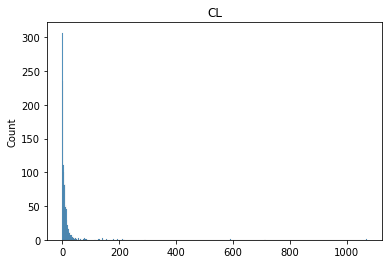

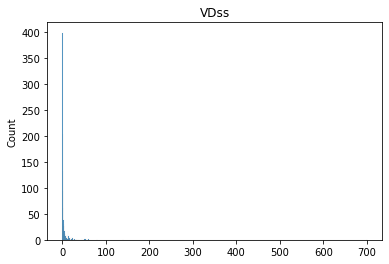

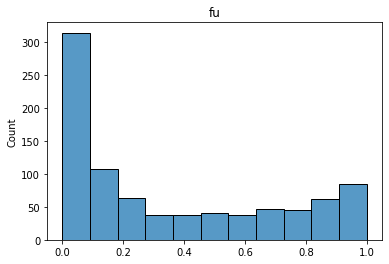

In [12]:
### plot data distribution

my_cmap = ListedColormap(["darkslategrey", "#96AC35"])

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')

data_objs = [pickle.load(open(fname, 'rb')) for fname in fnames]

for data in data_objs:
    y_all = np.concatenate([data.y, data.y_ind], axis=0)
    sns.histplot(data=y_all)
    plt.title(data.valuecol)
    plt.savefig(f"{base_dir}/figures/dataset/{data.valuecol}_distribtion.png", dpi=300, bbox_extra_artists=(lgd,ax), bbox_inches='tight')
    plt.show()
    

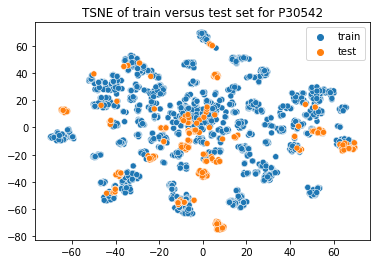

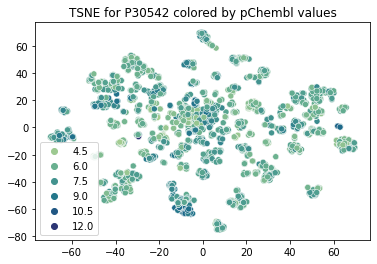

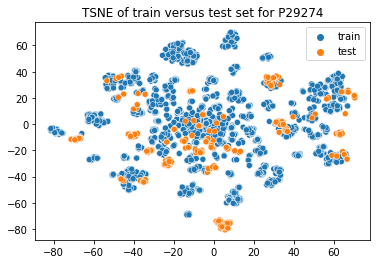

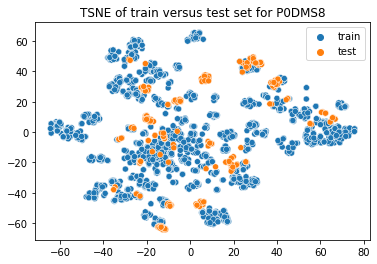

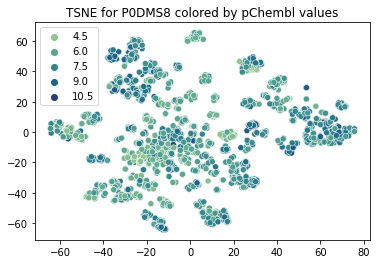

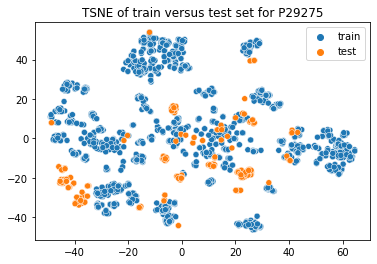

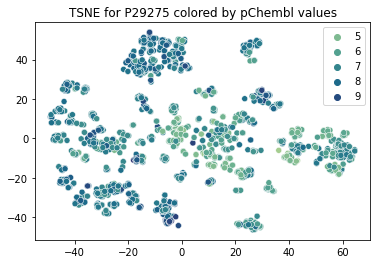

In [13]:

warnings.filterwarnings(action='ignore', category=FutureWarning)

def dataset_pca(data, out, alg = "TSNE"):

    X_all = np.concatenate([data.X, data.X_ind], axis=0)
    y_all = np.concatenate([data.y, data.y_ind], axis=0)
    traintest = np.concatenate([['train']*len(data.y), ['test']*len(data.y_ind)], axis=0)
    
    fps = Scaler().fit_transform(X_all)
    red_alg = PCA(n_components=2) if alg == 'PCA' else TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
    xy = red_alg.fit_transform(fps)

    plt.figure()
    comp_X, comp_Y = xy[:, 0], xy[:, 1]
    sns.scatterplot(x=comp_X, y=comp_Y, hue=traintest)
    plt.title(f"{alg} of train versus test set for {data.target}")
    plt.savefig(f"{out}/{alg}_{data.target}_by_dataset.png")
    plt.show()

    plt.figure()
    Xtsne, Ytsne = xy[:, 0], xy[:, 1]
    sns.scatterplot(x=comp_X, y=comp_Y, hue=y_all, palette = sns.color_palette("crest", as_cmap=True))
    plt.title(f"{alg} for {data.target} colored by pChembl values")
    plt.savefig(f"{out}/{alg}_{data.target}_by_pChembl.png")
    plt.show()
    # plt.close()

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')

for fname in fnames:
    if "REG" in fname:
        data = pickle.load(open(fname, 'rb'))
        dataset_pca(data, out = f'{base_dir}/figures')

In [62]:
df = pd.read_csv(f"{base_dir}/data/dataset_d0002.tsv", sep="\t")
df = df[["SMILES", "accession", "pchembl_value_Mean"]]
df = df.pivot(index="SMILES", columns="accession", values="pchembl_value_Mean")

with open(f"{base_dir}/figures/dataset/dataset_info.txt", mode='a') as fname:
    print(f"Number of unique smiles in dataset: {df.shape[0]}")
    print(f"Number of unique smiles in dataset: {df.shape[0]}", file=fname)

    all = df[~df.isnull().any(axis=1)]
    print(f"Number with experimental values for A2A, A2B, A1 and A3: {all.shape[0]}")
    print(f"Number with experimental values for A2A, A2B, A1 and A3: {all.shape[0]}", file=fname)
    activeA2AandA2B = all[(all["P29274"]>6.5) & (all["P29275"]>6.5)].shape[0]
    print(f"Number active for A2A and A2B: {activeA2AandA2B}")
    print(f"Number active for A2A and A2B: {activeA2AandA2B}", file=fname)
    desired = all[(all["P0DMS8"]<6.5) & (all["P30542"]<6.5) & (all["P29274"]>6.5) & (all["P29275"]>6.5)].reset_index()
    print(f"Number active for A2A and A2B and inactive A1 and A3: {desired.shape[0]}")
    print(f"Number active for A2A and A2B and inactive A1 and A3: {desired.shape[0]}", file=fname)

    PandasTools.AddMoleculeColumnToFrame(desired, smilesCol = "SMILES", molCol = "mols")

Number of unique smiles in dataset: 6741
Number with experimental values for A2A, A2B, A1 and A3: 1405
Number active for A2A and A2B: 282
Number active for A2A and A2B and inactive A1 and A3: 32


accession,SMILES,P0DMS8,P29274,P29275,P30542,mols
0,CC(=O)Nc1ccc(-c2ccncc2)c(-c2ccco2)n1,6.480,6.680,8.152,6.450,
1,CC(C)(C)CC(=O)Nc1c(F)cc(C(=O)Nc2nccs2)cc1F,5.000,8.230,6.580,6.390,
2,CC(C)=CCn1cc2c(nc(NC(=O)Nc3cccc(Cl)c3)n3nc(-c4...,6.260,6.960,7.091,6.452,
3,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(OCC(=O)NCCCCCC4=C...,5.340,7.230,8.230,6.150,
4,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(CC...,6.000,6.570,8.068,5.000,
5,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(Cc...,5.000,6.840,9.155,5.250,
6,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(Cc...,4.750,6.950,8.525,6.352,
7,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(Cc...,4.520,6.512,8.890,5.582,
8,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(Cc...,4.620,6.792,8.915,5.962,
9,CCCn1c(=O)[nH]c2[nH]c(-c3ccc(S(=O)(=O)N4CCN(Cc...,6.000,6.560,9.064,5.640,

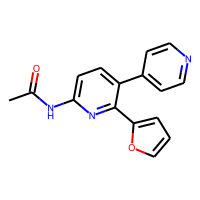
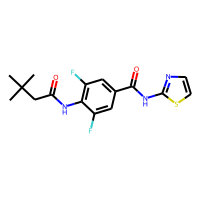
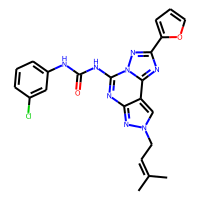
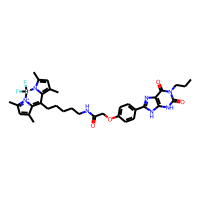
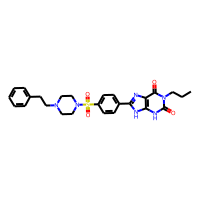
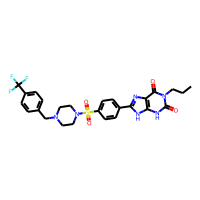
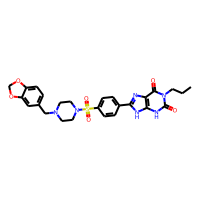
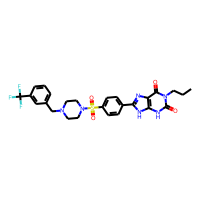
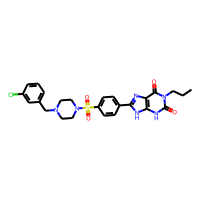
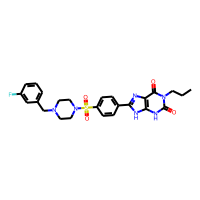
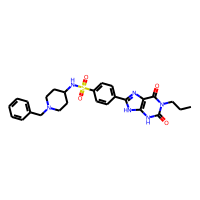
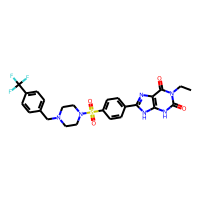
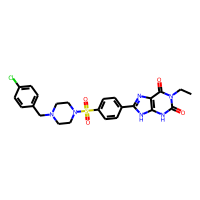
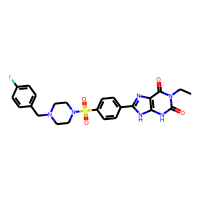
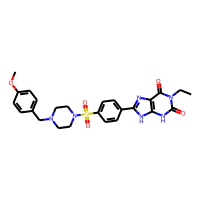
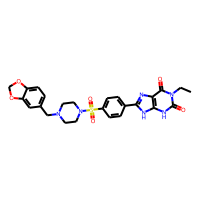
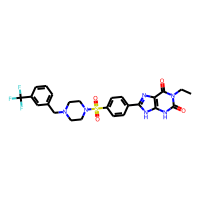
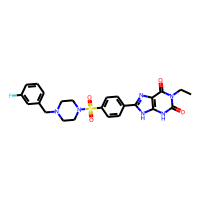
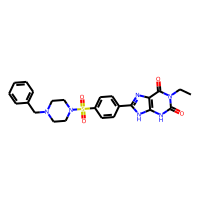
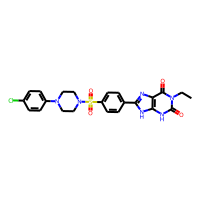
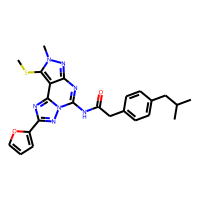
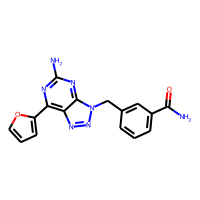
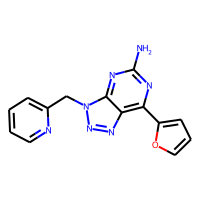
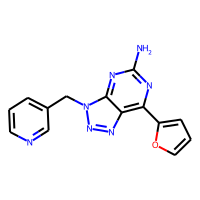
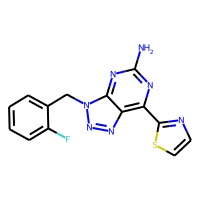
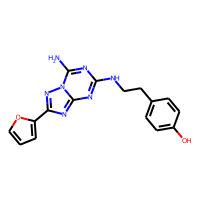
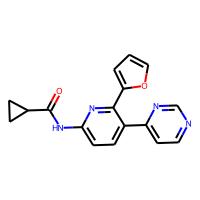
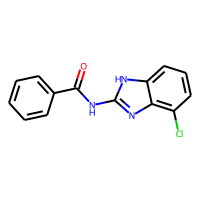
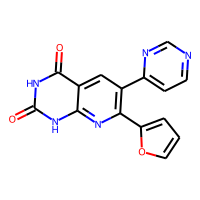
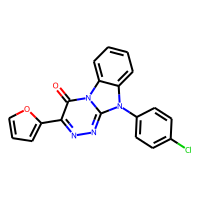
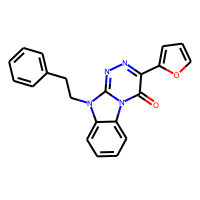
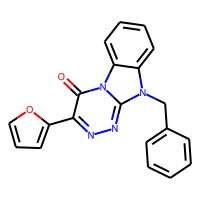

In [61]:
desired

In [73]:
# read in dataset and make activity bool
df = pd.read_csv(f"{base_dir}/data/dataset_d0002.tsv", sep="\t")
df = df[["SMILES", "accession", "pchembl_value_Mean"]]
df["pchembl_value_Mean"] = df["pchembl_value_Mean"] > 6.5
df = df.pivot(index="SMILES", columns="accession", values="pchembl_value_Mean").reset_index()

# use predictors to fill gaps with no activty
RF_A1 = Predictor.fromFile(f"{base_dir}/envs/RF_CLS_P30542.pkg", name="RF_A1", type="CLS")
RF_A2A = Predictor.fromFile(f"{base_dir}/envs/RF_CLS_P29274.pkg", name="RF_A2A", type="CLS")
RF_A2B = Predictor.fromFile(f"{base_dir}/envs/RF_CLS_P29275.pkg", name="RF_A2B", type="CLS")
RF_A3 = Predictor.fromFile(f"{base_dir}/envs/RF_CLS_P0DMS8.pkg", name="RF_A3", type="CLS")

PandasTools.AddMoleculeColumnToFrame(df, smilesCol = "SMILES", molCol = "mols")

df['P30542'] =  df['P30542'].fillna(pd.Series(RF_A1.getScores(df["mols"])))
df['P29274'] =  df['P29274'].fillna(pd.Series(RF_A2A.getScores(df["mols"])))
df['P29275'] =  df['P29275'].fillna(pd.Series(RF_A2B.getScores(df["mols"])))
df['P0DMS8'] =  df['P0DMS8'].fillna(pd.Series(RF_A3.getScores(df["mols"])))

df[['P30542', 'P29274', 'P29275', 'P0DMS8']] = df[['P30542', 'P29274', 'P29275', 'P0DMS8']] > 0.5

with open(f"{base_dir}/figures/dataset/dataset_info.txt", mode='a') as fname:
    activeA2AandA2B = df[df["P29274"] & df["P29275"]].shape[0]
    print(f"Number active for A2A and A2B missing data predicted: {activeA2AandA2B}")
    print(f"Number active for A2A and A2B missing data predicted: {activeA2AandA2B}", file = fname)
    desired = df[~(df["P0DMS8"] & df["P30542"]) & (df["P29274"] & df["P29275"])].shape[0]
    print(f"Number active for A2A and A2B and inactive A1 and A3 missing data predicted: {desired}")
    print(f"Number active for A2A and A2B and inactive A1 and A3 missing data predicted: {desired}", file = fname)

Number active for A2A and A2B missing data predicted: 1836
Number active for A2A and A2B and inactive A1 and A3 missing data predicted: 1445


In [74]:
####---Sphere exclusion picker---###
from rdkit.SimDivFilters.rdSimDivPickers import LeaderPicker
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import cairosvg

def LeaderMoleculePicker(fps, thresh=0.65):
    """
    Selects a number of diverse molecules from a list of molecular fingerprints based on tanimoto distance
    following the Leader picker sphere exclusion algorithm and prints the similarity between selected fingerprints.
    Adapted from: https://rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html

    Arguments:
        fps (np.array): molecular fingerprints
        num_mols (int): number of diverse molecules picked
        random_seed (int): random seed for intialization of LeaderPicker

    Returns:
        pickIndices (list): indices of selected diverse molecular fingerprints (corresponding to fps)
    """
    picker = LeaderPicker()
    pickIndices = picker.LazyBitVectorPick(fps, len(fps), thresh)
    print("Picked Indices: ", list(pickIndices))

    pickfps = [fps[x] for x in pickIndices]
    nearest = []
    simhist = []
    for i,fpi in enumerate(pickfps):
        tfps = pickfps[:]
        del tfps[i]
        sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
        nearest.append(max(sims))
        simhist.extend(sims)
    print("Picked Compound similarities: ", sorted(nearest,reverse=True)[:10])
        
    plt.hist(simhist,bins=20)
    plt.xlabel('similarity')

    return pickIndices

from collections import defaultdict
def assignPointsToClusters(pickIndices, fps):
    """
        Defines the picked compounds to be the centroids of clusters
        and then assign each other compound in the dataset to the nearest cluster centroid.
        From: https://rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html

        Arguments:
            pickIndices (list): indices of selected diverse molecular fingerprints (corresponding to fps)
            fps (np.array): molecular fingerprints
        
        Returns:
            clusters (dict): Dictionary of clusters with as values lists of all indices of compounds belong to
                             that cluster 
    """
    
    clusters = defaultdict(list)
    for i,idx in enumerate(pickIndices):
        clusters[i].append(idx)
    sims = np.zeros((len(pickIndices),len(fps)))
    for i in range(len(pickIndices)):
        pick = pickIndices[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in pickIndices:
            clusters[idx].append(i)
    clusters = dict(sorted(clusters.items(), key = lambda item: len(item[1]), reverse = True))
    return clusters

In [75]:
#clustering the desired molecules
from matplotlib import pyplot as plt
import numpy as np

desired = df[~(df["P0DMS8"] & df["P30542"]) & (df["P29274"] & df["P29275"])]

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048) for mol in desired.mols]

#Get diverse compounds from dataset
pickIndices = LeaderMoleculePicker(list(fps), thresh=0.85)

img = Draw.MolsToGridImage([desired.mols.iloc[x] for x in pickIndices[:10]], molsPerRow=5, subImgSize=(800,800), useSVG=True)

molsvg = img.data
f = open(f"{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.svg", "w")
f.write(molsvg)
f.close()
cairosvg.svg2png(url=f'{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.svg',
                write_to= f"{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.png",
                scale=3.0,
                dpi = 300)

clusters = assignPointsToClusters(pickIndices,fps)
plt.hist([len(clusters[x]) for x in clusters])
plt.xlabel('cluster size')

for i in range(10):
    img = Draw.MolsToGridImage([AllChem.MolFromSmiles(desired.SMILES.iloc[x]) for j, x in enumerate(clusters[i]) if j <= 9],
                                subImgSize=(800,800), molsPerRow=5, useSVG=True)
    molsvg = img.data
    f = open(f"{base_dir}/figures/dataset/clustering/Leader/cluster%s.svg" % i, "w")
    f.write(molsvg)
    f.close()
    cairosvg.svg2png(url=f'{base_dir}/figures/dataset/clustering/Leader/cluster%s.svg' % i,
                  write_to= f'{base_dir}/figures/dataset/clustering/Leader/cluster%s.png' % i,
                  scale=3.0)
    plt.close()


Picked Indices:  [0, 1, 2, 3, 10, 12, 22, 29, 50, 59, 66, 75, 81, 88, 92, 97, 245, 345, 435, 458, 470, 490, 496, 552, 558, 649, 706, 755, 873, 993, 1010, 1082, 1102, 1246, 1340, 1365]
Picked Compound similarities:  [0.14953271028037382, 0.14953271028037382, 0.14935064935064934, 0.14935064935064934, 0.14893617021276595, 0.14893617021276595, 0.1487603305785124, 0.1485148514851485, 0.1485148514851485, 0.14814814814814814]


accession,SMILES,P0DMS8,P29274,P29275,P30542,mols
0,Brc1cccc(Nc2nc3c(N4CCCC4)ncnc3s2)c1,False,True,False,False,
1,C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C,False,False,False,True,
2,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,False,False,False,False,
3,C#CCCC(=O)Nc1nc2nn(C)cc2c2nc(-c3ccco3)nn12,True,True,False,False,
4,C#CCCCC#Cc1nc(NCc2cccc(Cl)c2)c2ncn(C3C(O)C(O)C...,True,False,False,False,
...,...,...,...,...,...,...
6736,c1nc2c(NC3CCCCC3)nc(Nc3ccc(N4CCOCC4)cc3)nc2[nH]1,False,False,False,False,
6737,c1nc2c(NC3CCCCCC3)nc(Nc3ccc(N4CCOCC4)cc3)nc2[nH]1,False,False,False,False,
6738,c1nc2c(NC3CCCCCCC3)nc(Nc3ccc(N4CCOCC4)cc3)nc2[...,False,False,False,False,
6739,c1nc2nc(Nc3ccc(N4CCOCC4)cc3)nc(NC3CC3)c2[nH]1,False,False,False,False,

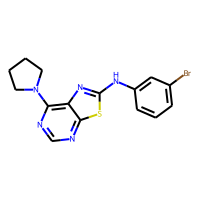
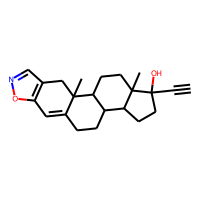
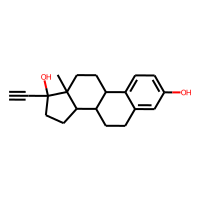
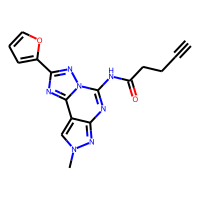
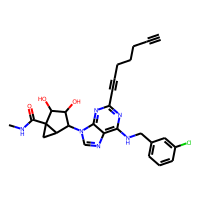
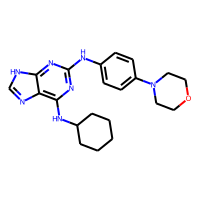
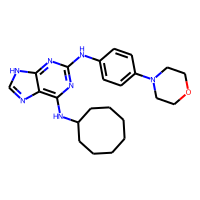
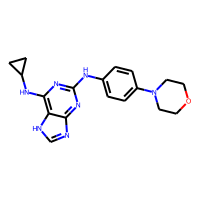
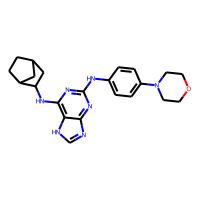

In [76]:
df

/tmp/ipykernel_2427366/283647987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired["Cluster"] = np.NaN
/tmp/ipykernel_2427366/283647987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired["Cluster_Center"] = False
/tmp/ipykernel_2427366/283647987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desired.

ValueError: The palette list has the wrong number of colors.

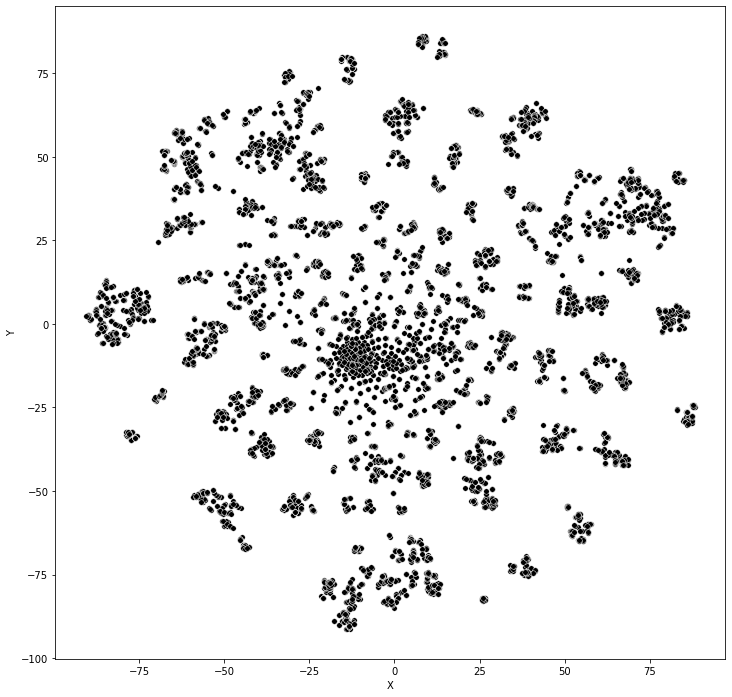

In [77]:
desired["Cluster"] = np.NaN
desired["Cluster_Center"] = False
for cluster_idx, cluster in enumerate(clusters.values()):
        for i, mol_idx in enumerate(cluster):
                desired.loc[:,"Cluster"].iloc[mol_idx] = cluster_idx
desired.loc[:,"Cluster_Center"].iloc[pickIndices] = True

# ECFP fingerprints tsne
df = df.merge(desired[["SMILES", "Cluster", "Cluster_Center"]], on=["SMILES"], how="left")
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048) for mol in df.mols]
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
xy = tsne.fit_transform(np.array(fps))

df['X'], df['Y'] = xy[:, 0], xy[:, 1]

plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x="X", y="Y", s=30, color="black")
sns.scatterplot(data=df[~df["Cluster"].isna()], x="X", y="Y", s=30, hue="Cluster", palette=sns.color_palette("husl", 37))

sns.scatterplot(data=desired[~desired.Cluster_Center], x='X', y='Y', hue='Cluster',s = 30)
sns.scatterplot(data=desired[(desired.Cluster_Center) & (desired.Cluster < 10)], x='X', y='Y',
                color='black', marker = 'X', s = 100)

test = df[(df.Cluster_Center) & (df.Cluster < 10)]
for i, txt in enumerate(range(10)):
    plt.gca().annotate(txt, (test["X"].iloc[i]+0.5, test["Y"].iloc[i]+0.5), size=10)

plt.savefig(f'{base_dir}/figures/clustering/Leader/tsne_clustering.png', dpi=300, bbox_inches='tight')
plt.close()


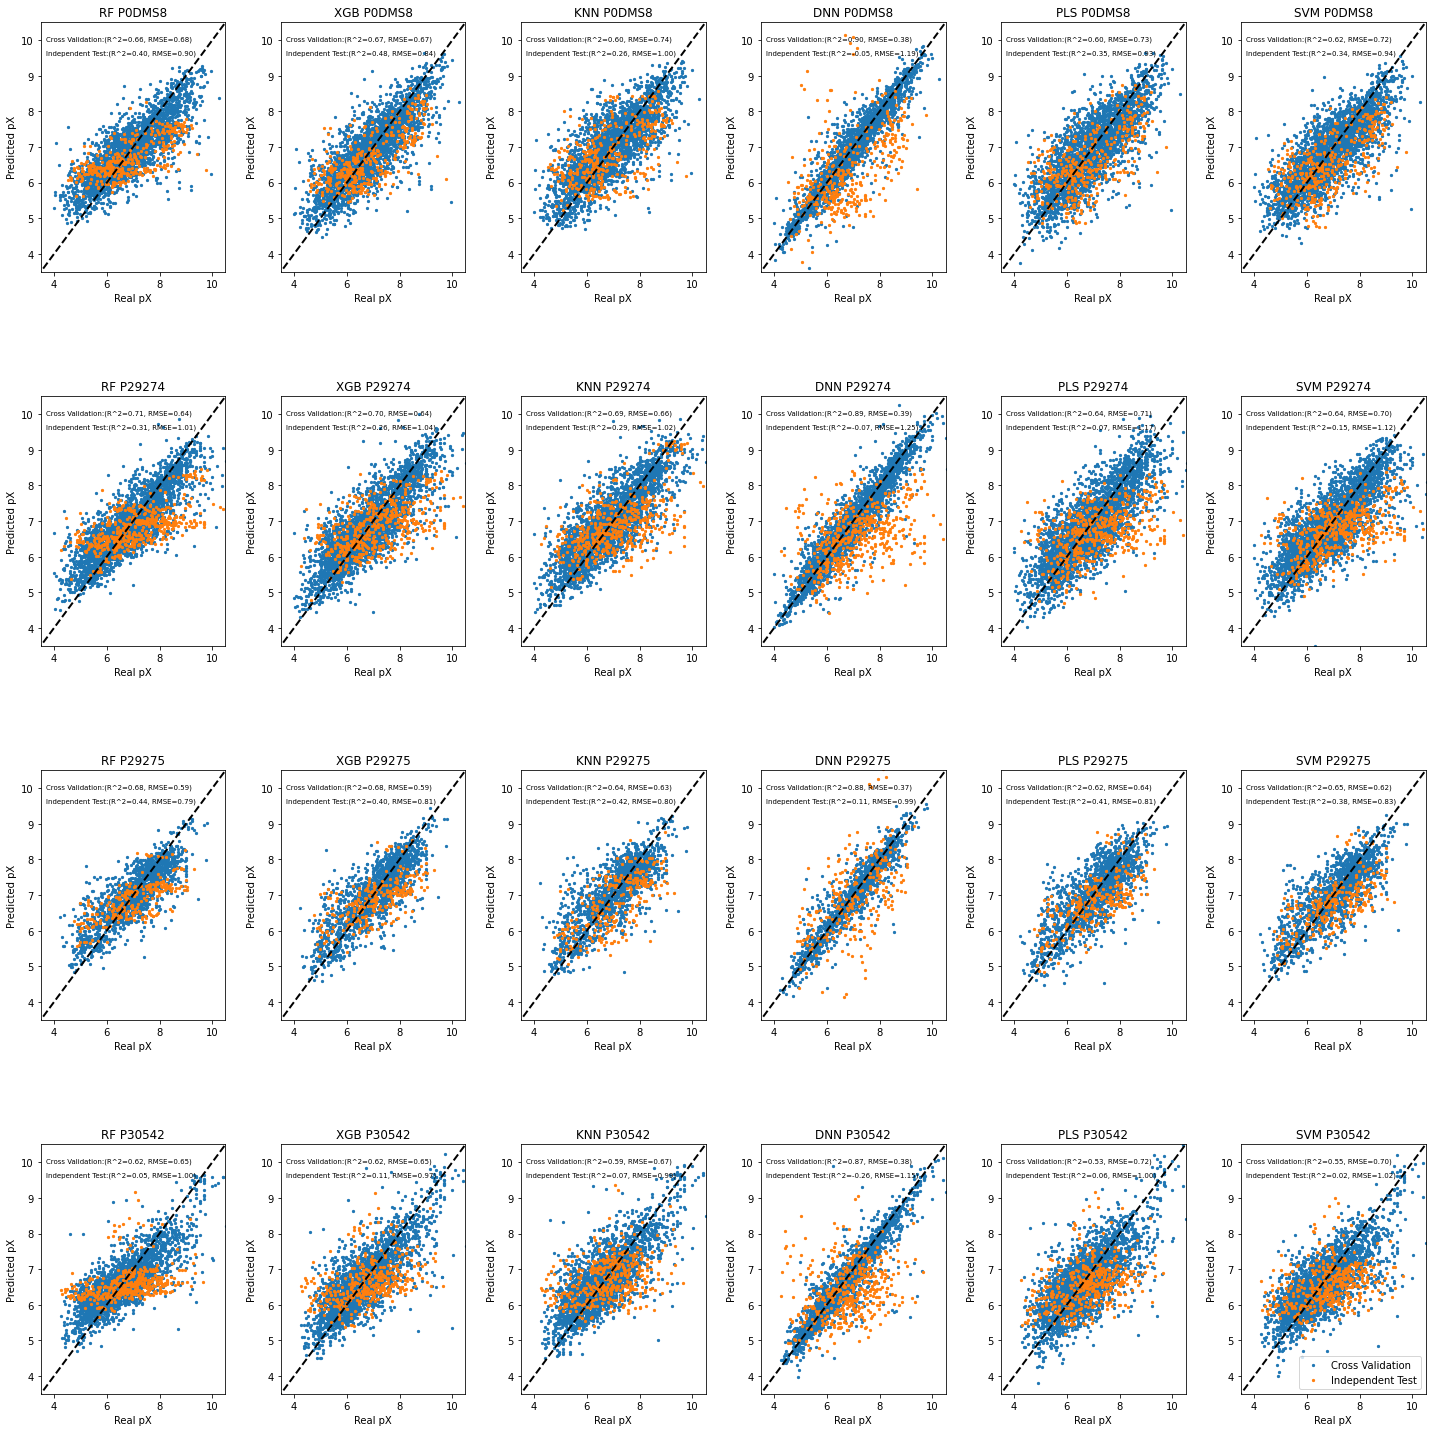

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
def QSKR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    plt.figure(figsize=(20, 20))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation', 'Independent Test']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=5, label=legend)
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                # print('%s %s:(R^2=%.2f, RMSE=%.2f)' % (model, legend,coef,rmse))
                plt.annotate('%s:(R^2=%.2f, RMSE=%.2f)' % (legend,coef,rmse), xy=[3.7,10-0.4*j],fontsize=7)

            plt.title('%s %s' % (model,target))
            plt.xlim([3.5, 10.5])
            plt.ylim([3.5, 10.5])
            plt.xlabel('Real pX')
            plt.ylabel('Predicted pX')
            plt.plot([0, 11], [0, 11], color='black', lw=2, linestyle='--')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)


QSKR_REG_scatterplot(f"{base_dir}/envs/",
                     ["P0DMS8", "P29274", "P29275", "P30542"], 
                     ["RF", "XGB", "KNN", "DNN", "PLS", "SVM"],
                      out=f"{base_dir}/figures/QSKR_REG_scatterplot.pdf")

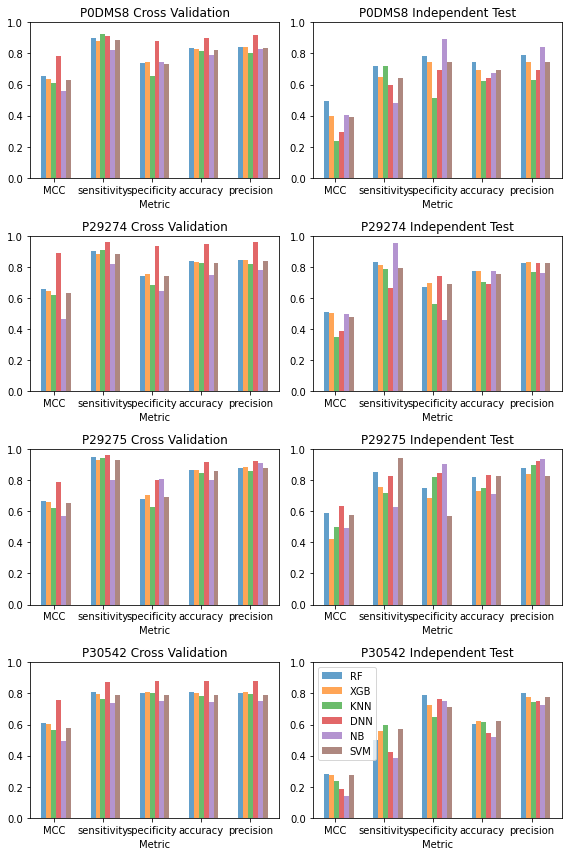

In [27]:
import numpy as np

def QSKR_CLS_metrics(infolder, targets, models, out=None):
    """
    Function to plot the results of classification models with different metrics (MCC, Sensitivity, specificity, accuracy) 
    """
    plt.figure(figsize=(8, 12))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        mymetrics = ['MCC', 'sensitivity', 'specificity', 'accuracy', 'precision']
        barWidth = 0.1
        for j, legend in enumerate(['Cross Validation', 'Independent Test']):
            plt.subplot(len(targets),2,1 + i*2 + j)
            for k, model in enumerate(models):
                df = pd.read_table('%s/%s_CLS_%s.%s.tsv' % (infolder, model, target, cate[j]))
                df.Score = df.Score>0.5
                MCC = metrics.matthews_corrcoef(df.Label, df.Score)
                SEN = metrics.recall_score(df.Label, df.Score)
                CM = metrics.confusion_matrix(df.Label, df.Score)
                SPE = CM[0,0]/(CM[0,1]+CM[0,0]) # TN/(FP+TN)
                ACC = metrics.accuracy_score(df.Label, df.Score)
                PRE = metrics.precision_score(df.Label, df.Score)
                pos = [x + barWidth * k + barWidth * 0.3 * j for x in np.arange(len(mymetrics))]
                plt.bar(pos, [MCC,SEN,SPE,ACC,PRE], width = barWidth, label=model, alpha=0.7)
            plt.title('%s %s' % (target,legend))
            plt.xticks([x + barWidth * 2 for x in np.arange(len(mymetrics))], mymetrics)
            plt.ylim((0,1))
            plt.xlabel('Metric')
    plt.legend(loc='upper left')
    plt.tight_layout()
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

QSKR_CLS_metrics(f"{base_dir}/envs/",
                     ["P0DMS8", "P29274", "P29275", "P30542"], 
                     ["RF", "XGB", "KNN", "DNN", "NB", "SVM"],
                      out="{base_dir}/figures/QSKR_CLS_metrics.png")


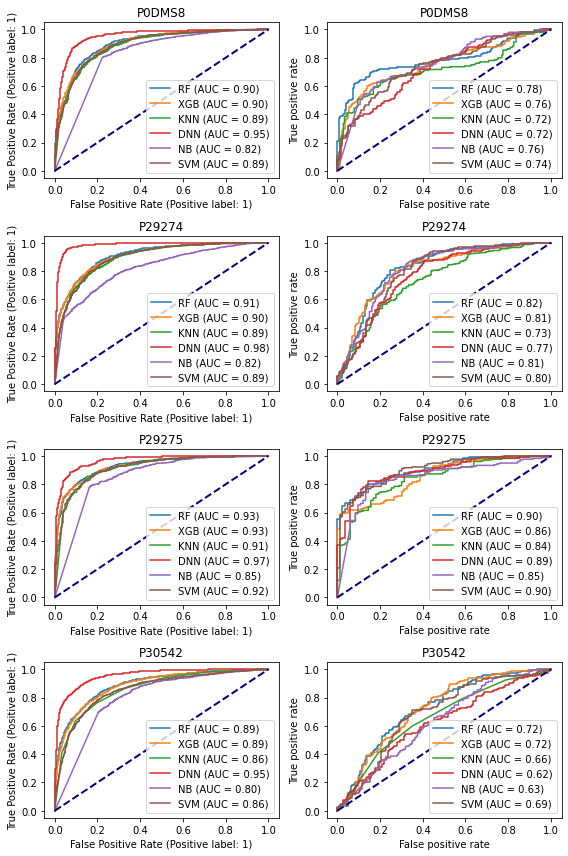

In [2]:
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd

def QSKR_CLS_ROC(infolder, targets, models, out=None):
    """
    Function to plot the results of classification models in a ROC curve.
    """
    plt.figure(figsize=(8, 12))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for j, legend in enumerate(['Cross Validation', 'Independent Test']):
            plt.subplot(len(targets),2,1 + i*2 + j)
            for model in models:
                df = pd.read_table('%s/%s_CLS_%s.%s.tsv' % (infolder, model, target, cate[j]))
                ax = plt.gca()
                metrics.RocCurveDisplay.from_predictions(df.Label, df.Score, ax = ax, name="%s" % model)
            plt.title(target)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    #ax.legend(handles, labels, loc='lower right')
    plt.tight_layout()
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300, bbox_inches='tight')

QSKR_CLS_ROC("AdenosineReceptors_v4/envs/",
                     ["P0DMS8", "P29274", "P29275", "P30542"], 
                     ["RF", "XGB", "KNN", "DNN", "NB", "SVM"],
                      out="AdenosineReceptors_v4/figures/QSKR_CLS_ROC.png")


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


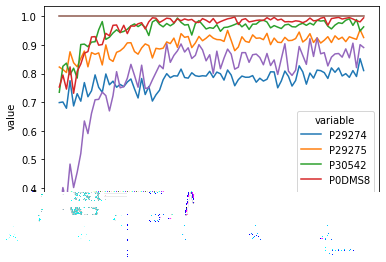

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

RL = pd.read_csv("AdenosineReceptors_v4/generators/ligand_smiles_rnn_RL_smiles.tsv", sep="\t")

RL = RL.groupby('Epoch', as_index = False).mean()

RL = RL.melt(id_vars='Epoch')

sns.lineplot(data=RL, x='Epoch', y='value', hue='variable')

plt.savefig("AdenosineReceptors_v4/figures/average_score_per_epoch_RL.png", dpi=300)